# Data Preprocessing and Dimensionality Reduction

This notebook prepares the Superconductor dataset for regression experiments.
We perform the following steps:

1. Load and inspect the dataset
2. Standardize all feature variables
3. Apply PCA as a dimensionality reduction technique
4. Create two versions of the dataset:
   - Standardized (raw feature space)
   - PCA-reduced feature space

These datasets will be used in later notebooks to study how kernel choice and
dimensionality reduction affect regression performance.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
# load the data set
df = pd.read_csv("../data/train.csv")

df.shape


(21263, 82)

In [3]:
# inspect the column names
df.columns


Index(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie', 'wtd_mean_fie',
       'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_entropy_fie',
       'range_fie', 'wtd_range_fie', 'std_fie', 'wtd_std_fie',
       'mean_atomic_radius', 'wtd_mean_atomic_radius', 'gmean_atomic_radius',
       'wtd_gmean_atomic_radius', 'entropy_atomic_radius',
       'wtd_entropy_atomic_radius', 'range_atomic_radius',
       'wtd_range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius',
       'mean_Density', 'wtd_mean_Density', 'gmean_Density',
       'wtd_gmean_Density', 'entropy_Density', 'wtd_entropy_Density',
       'range_Density', 'wtd_range_Density', 'std_Density', 'wtd_std_Density',
       'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity',
       'gmean_

In [4]:
# define the regression target column
target_column = "critical_temp"

# extract target variable
y = df[target_column]
# Extract feature matrix by dropping the target column
X = df.drop(columns=[target_column])

X.shape, y.shape


((21263, 81), (21263,))

In [5]:
# store number of samples and features for reporting
n_samples, n_features = X.shape

n_samples, n_features


(21263, 81)

In [6]:
# check total number of missing values in the dataset
df.isnull().sum().sum()


np.int64(0)

## Feature Standardization

All feature variables are standardized to have zero mean and unit variance.
This step is essential because:

- The dataset contains features measured on very different scales
- PCA is sensitive to feature variance
- Kernel-based regression methods rely on distance or inner-product computations

Standardization ensures that no feature dominates the analysis purely due to
its numerical scale.


In [7]:
# initialize a scaler and fit it on the feature matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
np.save("../data/X_scaled.npy", X_scaled)
np.save("../data/y.npy", y.to_numpy())


## Principal Component Analysis (PCA)

PCA is applied to the standardized feature matrix to reduce dimensionality and
remove correlations between features. The dataset contains many groups of
strongly related variables (e.g., multiple summary statistics of the same
physical properties), making PCA a suitable dimensionality reduction method.

We first analyze the cumulative explained variance to guide the choice of the
number of principal components.


In [8]:
# fit PCA without restricting the number of components
pca_full = PCA()
pca_full.fit(X_scaled)

# compute cumulative explained variance ratio
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)


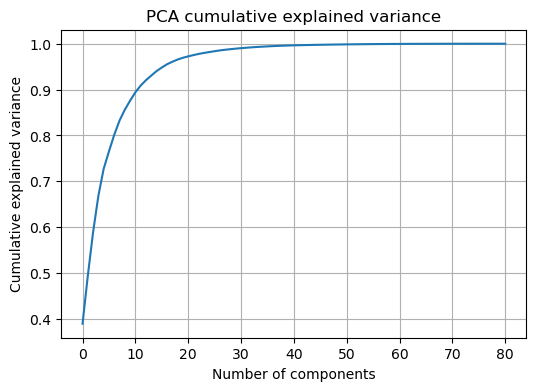

In [9]:
# plot cumulative explained variance to visualize variance retention
plt.figure(figsize=(6, 4))
plt.plot(cumulative_variance)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA cumulative explained variance")
plt.grid(True)
plt.show()


## Choice of Number of Components

We select the smallest number of principal components that explain at least
95% of the total variance in the data. This criterion balances dimensionality
reduction with information preservation.


In [12]:
variance_threshold = 0.95
n_components = np.argmax(cumulative_variance>= variance_threshold) + 1
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
print(X_pca.shape)
# save PCA-reduced features for later experiments
np.save("../data/X_pca.npy", X_pca)

(21263, 17)


In [13]:
X_reconstructed = pca.inverse_transform(X_pca)
reconstruction_error = np.mean((X_scaled - X_reconstructed) ** 2)
print(f"Reconstruction error with {n_components} components: {reconstruction_error:.4f}")

Reconstruction error with 17 components: 0.0447
